<a href="https://colab.research.google.com/github/nicoleluduvice/Case/blob/main/case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risco de crédito para financiamento de veículos

Este projeto busca ajustar um modelo supervisionado que busca minimizar o risco de crédito para o financiamento de veículos.

Temos uma base de dados de 7k cliente que obtiveram o financiamento aprovado.

A variável M30over30 que representa cliente em atraso com mais de 30 dias após três meses da contratação será usada como variavel resposta do modelo.

In [32]:
# Carregando pacotes..
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, roc_curve, roc_auc_score, confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score

#from sklearn.metrics import mean_squared_error, r2_score


--------------------------
## Pré-processamento

A base contém 11 colunas e 7k linhas com informações sobre os clientes.



In [3]:
! git clone https://github.com/nicoleluduvice/Case.git

Cloning into 'Case'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 238.97 KiB | 1.67 MiB/s, done.


In [4]:
df_raw = pd.read_csv("Case/dados.txt", sep = ";")
df_raw

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11,1,37.0,SC,20728.584790,17490.004917,63571.250171,719.000000,"41896,12",2021.0
6996,6996,2021-10,0,27.0,SP,11780.381806,250.000000,0.000000,990.681716,"38848,43",2021.0
6997,6997,2021-10,0,24.0,SC,39445.186665,398.000000,0.000000,885.814411,"43202,45",2020.0
6998,6998,2021-10,0,45.0,SP,4800.000000,18081.477110,44415.298425,850.907405,"34693,58",2021.0


A etapa de pre-processamento dos dados é uma etapa fundamental na construção dos modelos.

Alguns tratamentos importantes a ser realizados são:
1. Tratar as variáveis?
3. Existem outliers "impossíveis"?
3. Como tratar dados categóricos?
3. Linhas duplicadas?
2. Como lidar com valores ausentes?
3. Variável resposta muito desbalanceada?


#### 1. Tratar as variáveis

Tratar as variáveis, como limpar, categorizar ou remover variáveis é uma etapa fundamental para um bom desempenho do modelo.

Observamos que as variável "Valor do veiculo" está com a classe errada. A coluna possui uma natureza numérica, mas sua classe é objeto. Vamos arrumar converte-la para numérico.

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CLIENTE                      7000 non-null   int64  
 1   DATA_FINANCIAMENTO           7000 non-null   object 
 2   TARGET_M3OVER30              7000 non-null   int64  
 3   IDADE                        6981 non-null   float64
 4   ESTADO                       7000 non-null   object 
 5   RENDA                        7000 non-null   float64
 6   LIMITE_CARTAO                6934 non-null   float64
 7   VALOR_FINANC_VEICULOS_ATUAL  6934 non-null   float64
 8   SCORE_MERCADO                6980 non-null   float64
 9   VALOR_VEICULO                6997 non-null   object 
 10  ANO_VEICULO                  6997 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 601.7+ KB


In [6]:
df = df_raw.copy()
df.VALOR_VEICULO = pd.to_numeric(df_raw.VALOR_VEICULO.str.replace(",", "."))

É interessante verificar que O "valor do financiamento de veiculos atual, possui muitas observações zeradas (mais de 75% das observações).

Além disso, uma informação que pode ser relevante para o modelo é a proporção do valor do veiculo em relasção a renda do cliente.

Para isso, criamos duas novas variáveis "VALOR_FINANC_VEICULOS_ATUAL_CAT" e "prop_valor_veiculo_renda".

Essas duas informações serão adicionadas na base para fins de modelagem, buscando aprimorar a performance do modelo.

In [7]:

#retira cliente, data fiancniamento estado
df_modelo = df.copy()
df_modelo["VALOR_FINANC_VEICULOS_ATUAL_CAT"] = (df_modelo.VALOR_FINANC_VEICULOS_ATUAL > 0).astype(int).astype(str)
df_modelo["prop_valor_veiculo_renda"] = df_modelo.VALOR_VEICULO/df_modelo.RENDA
df_modelo = df_modelo[["CLIENTE", "TARGET_M3OVER30", "RENDA", "LIMITE_CARTAO", "IDADE", "VALOR_FINANC_VEICULOS_ATUAL_CAT", "SCORE_MERCADO", "prop_valor_veiculo_renda", "ANO_VEICULO", "DATA_FINANCIAMENTO", "ESTADO"]]
df = df_modelo

#### 2. Outliers

Ao observar a base, vemos que não existem números negativos e os valores estão dentro das faixas plausíveis (condizentes com a realidade).

In [8]:
df.describe()

,CLIENTE,TARGET_M3OVER30,RENDA,LIMITE_CARTAO,IDADE,SCORE_MERCADO,prop_valor_veiculo_renda,ANO_VEICULO
count,7000.000000,7000.000000,7000.000000,6934.000000,6981.000000,6980.000000,6997.000000,6997.000000
mean,3447.344714,0.285714,8213.636099,9038.877500,43.056869,753.905403,11.056567,2019.955838
std,2019.518927,0.451786,7928.804191,16043.678523,13.036693,164.039755,9.808270,1.370968
min,0.000000,0.000000,800.000000,0.000000,19.000000,1.462154,0.404898,2011.000000
25%,1694.750000,0.000000,2350.000000,1062.717500,32.000000,641.000000,3.359778,2020.000000
50%,3434.500000,0.000000,5510.253541,5427.814748,42.000000,773.831260,7.195716,2020.000000
75%,5183.250000,1.000000,11851.041243,12624.586563,53.000000,891.000000,16.625022,2021.000000
max,6999.000000,1.000000,106828.787747,709776.920000,77.000000,999.999903,61.454716,2021.000000


#### 3. Dados categoricos

Temos 2 variáveis com dados categóricos na base. Estado, com 6 estados do Brasil (SP, RJ, PR, MG, CE, SC) e data do financiamento que assumem valores de outubro, novembro e dezembro de 2021.

Também foi adicionada uma nova variável - VALOR_FINANC_VEICULOS_ATUAL_CAT - na etapa anterior.

Optaremos por utilizar o Label Encoder para codificar a variável 'data do financiamento' e 'VALOR_FINANC_VEICULOS_ATUAL_CAT' e o One-Hot Encoder para a variável 'Estado'. Essa decisão é motivada pelo fato de que a 'data do financiamento' assume uma ordem significativa entre as categorias, tornando o Label Encoder mais apropriado. Já a variável 'Estado' não possui essa natureza ordinal, razão pela qual optamos por empregar o One-Hot Encoder para essa variável.

In [9]:
labelencoder = LabelEncoder()
df['DATA_FINANCIAMENTO'] = labelencoder.fit_transform(df['DATA_FINANCIAMENTO'])
df["VALOR_FINANC_VEICULOS_ATUAL_CAT"] = labelencoder.fit_transform(df["VALOR_FINANC_VEICULOS_ATUAL_CAT"])

onehotencoder = OneHotEncoder(sparse=False, drop='first')
encoded_states = onehotencoder.fit_transform(df[["ESTADO"]])
df_enc_states = pd.DataFrame(encoded_states, columns=onehotencoder.get_feature_names_out(['ESTADO']))
df = pd.concat([df, df_enc_states], axis=1)
df = df.drop("ESTADO", axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### 4. Linhas duplicadas

Há na base de dados a presença do mesmo cliente em várias linhas. Em geral, uma pessoa pode solicitar mais de um financiamento no mesmo período e ser aprovada. No entanto, observamos inconsistências em algumas informações, especialmente a idade do cliente. Em circunstâncias normais, seria ideal comunicar-se com o responsável pela base de dados para esclarecer se as duplicatas de clientes são resultado de inconsistências ou se apenas algumas informações, como idade ou pontuação de mercado, estão desatualizadas.

Dado que não dispomos dessa informação no momento, para fins deste exercício, assumiremos que essas duplicatas são inconsistências e optaremos por manter apenas a primeira ocorrência de cada cliente.

In [10]:
df_raw[df_raw.duplicated(subset='CLIENTE', keep=False)].sort_values(by = "CLIENTE")

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
3489,3,2021-10,1,42.0,CE,12250.000000,11252.113450,118614.738643,769.284761,"45537,97",2020.0
2838,3,2021-12,1,40.0,CE,12250.000000,11252.113450,123895.953362,590.841985,"35304,28",2020.0
23,23,2021-12,1,31.0,SP,7302.746395,1370.581210,0.000000,841.738437,"27091,63",2020.0
4899,23,2021-12,1,32.0,SP,7302.746395,1370.581210,0.000000,794.428799,"47560,44",2020.0
...,...,...,...,...,...,...,...,...,...,...,...
6979,6979,2021-11,1,33.0,CE,1100.000000,0.000000,0.000000,835.960315,"38518,05",2020.0
6889,6985,2021-10,1,29.0,RJ,2050.000000,8158.994182,0.000000,641.000000,"42742,89",2020.0
6985,6985,2021-11,1,27.0,RJ,2050.000000,8158.994182,0.000000,924.096727,"34992,79",2020.0
2453,6999,2021-12,1,30.0,PR,1100.000000,15440.006121,0.000000,884.000000,"44550,91",2021.0


In [11]:
df = df.drop_duplicates(subset='CLIENTE', keep='first')

#### 6. Dados faltantes



In [12]:
null_count = df.isnull().sum()/df.shape[0]
null_count = pd.DataFrame(null_count)
null_count['count'] = df.isnull().sum()
null_count

,0,count
CLIENTE,0.000000,0
TARGET_M3OVER30,0.000000,0
RENDA,0.000000,0
LIMITE_CARTAO,0.008564,57
IDADE,0.002855,19
VALOR_FINANC_VEICULOS_ATUAL_CAT,0.000000,0
SCORE_MERCADO,0.003005,20
prop_valor_veiculo_renda,0.000451,3
ANO_VEICULO,0.000451,3
DATA_FINANCIAMENTO,0.000000,0


Observa-se que o numero de valores faltantes são pequenos em comparação com o número total de clientes. Além disso, todas as variáveis que possuem valores faltantes são de natureza numérica. Dessa forma, podemos tanto retirar as observações como imputa-las.

A opção de deletar as linhas, neste caso, deletaria 102 linhas ( um pouco mais de 1% da base de dados ). Para preservar os dados e evitar excluir dados que seguem algum padrão, optou-se por imputar os valores pela mediana.

Vale ressaltar que imputar o valor da mediana na base inteira pode causar "data leakage". Para evitar isso, a base de teste e treino será separada e o valor a ser imputado para ambas as bases será a mediana da base de treino.

In [13]:
# TRAIN/TEST SPLIT
X = df.drop(["CLIENTE", "TARGET_M3OVER30"], axis=1)
y = df["TARGET_M3OVER30"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [14]:
# IMPUTAR MEDIANA
num_cols = X_train.select_dtypes(exclude = "object").columns
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train.loc[:, num_cols])

# Imputa os valores faltantes nos dados de treino
X_train.loc[:, num_cols] = imputer.transform(X_train.loc[:, num_cols])
# Imputa os valores faltantes nos dados de teste usando a mediana da base de treino
X_test.loc[:, num_cols] = imputer.transform(X_test.loc[:, num_cols])

<ipython-input-14-5506eb847474>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.loc[:, num_cols] = imputer.transform(X_train.loc[:, num_cols])
<ipython-input-14-5506eb847474>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.loc[:, num_cols] = imputer.transform(X_test.loc[:, num_cols])


#### 5. Dados desbalanceados

 A distribuição desigual dos dados na variável alvo, conhecida como desbalanceamento, pode impactar o desempenho do modelo. Observamos que os dados do target estão desbalanceados.

 O desbalanceamento pode influenciar a capacidade do modelo de aprender eficazmente sobre a classe minoritária, prejudicando a generalização para novos dados.

 Vamos aplicar diuas técnicas de balanceamento de dados: SMOTE (que gera dados sintéticos da classe de inadimplente criando instâncias interpoladas entre exemplos existentes) e undersampling (que reduz aleatoriamente o número de instâncias da classe majoritária para que se alinhe com a quantidade de instâncias da classe minoritária).

 Vamos analisar, na etapa de modelagem, qual das abordagens se adapta melhor aos dados.

<Axes: xlabel='TARGET_M3OVER30', ylabel='Count'>

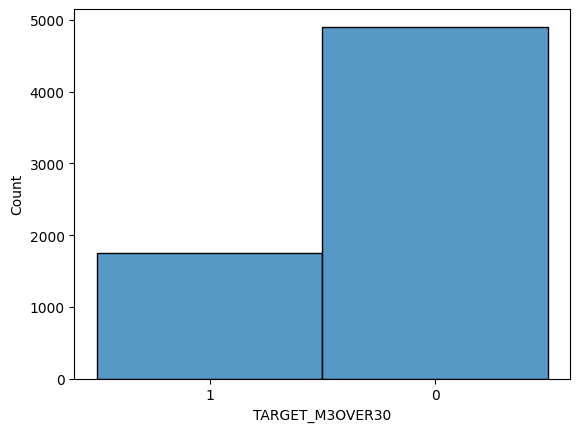

In [15]:
sbn.histplot(df["TARGET_M3OVER30"].astype(str))

In [16]:
smote = SMOTE(random_state=42)
X_resampled = pd.concat([X_train, X_test], axis=0)
y_resampled = pd.concat([y_train, y_test], axis=0)

X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=0)

<Axes: xlabel='TARGET_M3OVER30', ylabel='Count'>

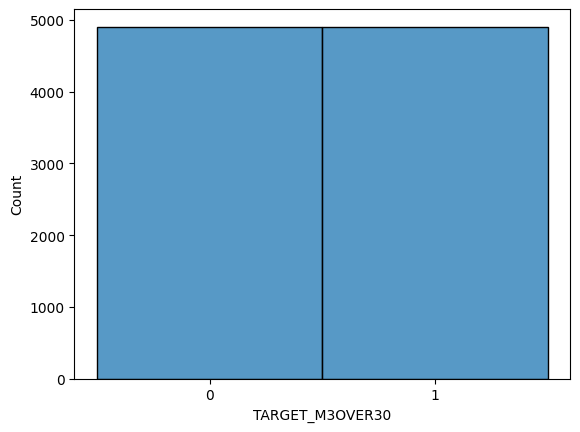

In [17]:
sbn.histplot(y_resampled.astype(str))

UNDER SAMPLER

In [18]:
rus = RandomUnderSampler()
X_undersampled =  pd.concat([X_train, X_test], axis=0)
y_undersampled = pd.concat([y_train, y_test], axis=0)
X_undersampled, y_undersampled = rus.fit_resample(X_undersampled, y_undersampled)

X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, y_undersampled, test_size=0.30, random_state=0)

<Axes: xlabel='TARGET_M3OVER30', ylabel='Count'>

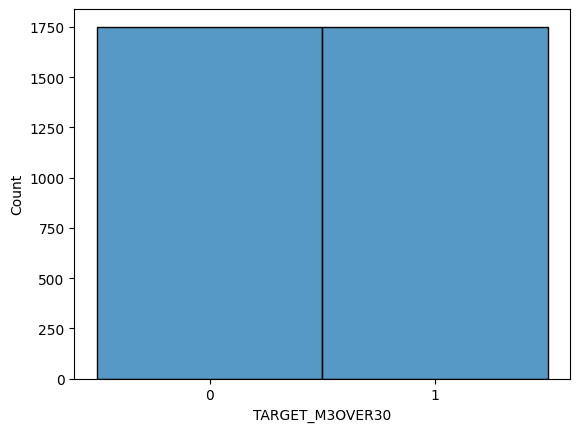

In [19]:
sbn.histplot(y_undersampled.astype(str))

-----------
## Análise descritiva

Qual é o perfil típico dos clientes que foram aprovados no financiamento de veículo?

* maioria de fato nao foi inadimplente (71.4%)

* 75% tem menos de 53 anos

* 75% possui renda maior que R$2350.00

* 22% das pessoas possuem "valor_financiamento_atual" diferente de 0

* 75% do score dos clientes é maior que 641.5





Vemos que, em geral, pessoas sem inadimplencia possuem uma renda e um score de mercado um pouco maior. Além disso, em mediana, a proporção do valor do veiculo em relação a renda é um pouco maior quando o cliente é inadimplete.

In [21]:
df_plot = df_raw.copy()
df_plot.VALOR_VEICULO = pd.to_numeric(df_plot.VALOR_VEICULO.str.replace(",", "."))
df_plot["TARGET_M3OVER30"] = df_raw["TARGET_M3OVER30"].astype(str)
df_plot.describe()

,CLIENTE,IDADE,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
count,7000.000000,6981.000000,7000.000000,6934.000000,6934.000000,6980.000000,6997.000000,6997.000000
mean,3447.344714,43.056869,8213.636099,9038.877500,9010.338687,753.905403,40126.071935,2019.955838
std,2019.518927,13.036693,7928.804191,16043.678523,24065.645965,164.039755,7464.934373,1.370968
min,0.000000,19.000000,800.000000,0.000000,0.000000,1.462154,16108.130000,2011.000000
25%,1694.750000,32.000000,2350.000000,1062.717500,0.000000,641.000000,34979.910000,2020.000000
50%,3434.500000,42.000000,5510.253541,5427.814748,0.000000,773.831260,39751.760000,2020.000000
75%,5183.250000,53.000000,11851.041243,12624.586563,0.000000,891.000000,44708.670000,2021.000000
max,6999.000000,77.000000,106828.787747,709776.920000,367302.807884,999.999903,97177.920000,2021.000000


<Axes: xlabel='RENDA'>

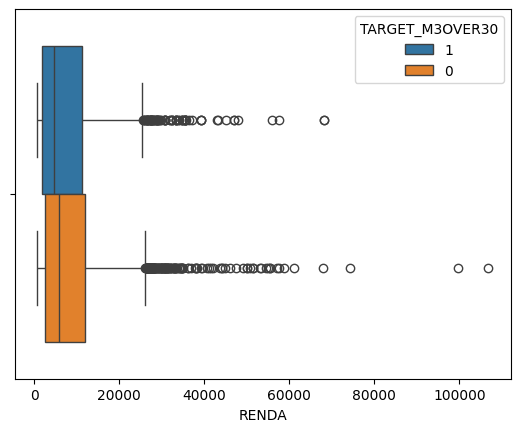

In [22]:
sbn.boxplot(x='RENDA', hue = "TARGET_M3OVER30", data=df_plot)
#sbn.countplot(x='VALOR_FINANC_VEICULOS_ATUAL', hue = "TARGET_M3OVER30", data=df_plot)

<Axes: xlabel='SCORE_MERCADO'>

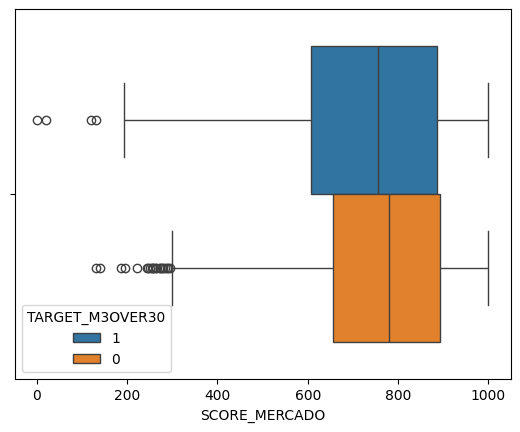

In [23]:
sbn.boxplot(x='SCORE_MERCADO', hue = "TARGET_M3OVER30", data=df_plot)

<Axes: xlabel='prop_valor_veiculo_renda'>

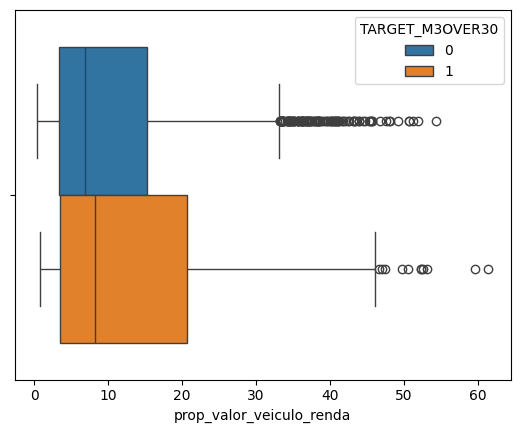

In [24]:
sbn.boxplot(x='prop_valor_veiculo_renda', hue = "TARGET_M3OVER30", data=df)

---------------------------
## MODELO

Iremos usar 3 modelos e observar qual é melhor:
- Regressao logistica
- Random Forest
- XGBoost

Também será testado qual abordagem de "resampling" é melhor.

In [34]:
def grid_search_and_predict(X_test, y_test, X_train, y_train, param_grid, random_state=42):
    # Create a Random Forest classifier
    rf_clf = RandomForestClassifier(random_state=random_state)

    print("1")
    # Perform grid search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='recall')
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Create a Random Forest classifier with the best hyperparameters
    best_rf_clf = RandomForestClassifier(**best_params, random_state=random_state)
    print("2")
    # Fit the model on the entire training set
    best_rf_clf.fit(X_train, y_train)

    print("3")
    # Make predictions on the test set
    y_pred = best_rf_clf.predict(X_test)
    print("4")
    cm = confusion_matrix(y_test, y_pred)
    print("5")
    acc = accuracy_score(y_test, y_pred)
    print("6")
    recall = recall_score(y_test, y_pred)
    # Return the predicted labels
    return [y_pred, best_rf_clf]

def grid_search_and_predict_xgboost(X_test, y_test, X_train, y_train, param_grid, random_state=42):
  xgb_model = xgb.XGBClassifier()
  # Perform GridSearchCV
  grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=5)
  grid_search.fit(X_train, y_train)

  # Get the best parameters and best model
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  # Predict on the test set using the best model
  y_pred = best_model.predict(X_test)

  return [y_pred, best_model]

In [36]:
# UNBALANCED
# Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_log = logistic_model.predict(X_test)


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgboost =  {
    'learning_rate': [0.01, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [ 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}
# Random Forest
y_pred_rf = grid_search_and_predict(X_test, y_test, X_train, y_train, param_grid )

# XGboost
y_pred_xgboost = grid_search_and_predict_xgboost(X_test, y_test, X_train, y_train, param_grid_xgboost )

data_raw = {
    'Name': ['Logistic','Random Forest', 'XGBoost'],
    'Type': ['Raw', "Raw", "Raw"],
    'accuracy': [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_xgboost[0]), accuracy_score(y_test, y_pred_rf[0])],
    'recall': [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_xgboost[0]), recall_score(y_test, y_pred_rf[0])]
}
data_raw


1
2
3
4
5
6


{'Name': ['Logistic', 'Random Forest', 'XGBoost'],
 'Type': ['Raw', 'Raw', 'Raw'],
 'accuracy': [0.7426139208813219, 0.7100650976464697, 0.7341011517275914],
 'recall': [0.00390625, 0.216796875, 0.109375]}

In [38]:
# UNDERSAMPLED

# Logistic Regression model
logistic_model_undersampled = LogisticRegression()
logistic_model_undersampled.fit(X_train_undersampled, y_train_undersampled)
y_pred_logistic_undersampled = logistic_model_undersampled.predict(X_test_undersampled)

# Random forest
y_pred_rf_undersampled = grid_search_and_predict(X_test_undersampled, y_test_undersampled, X_train_undersampled, y_train_undersampled, param_grid )

# XGboost
y_pred_xgboost_undersampled = grid_search_and_predict_xgboost(X_test_undersampled, y_test_undersampled, X_train_undersampled, y_train_undersampled, param_grid_xgboost )

data_under = {
    'Name': ['Logistic','Random Forest', 'XGBoost'],
    'Type': ['Undersampled', "Undersampled", "Undersampled"],
    'accuracy': [accuracy_score(y_test_undersampled, y_pred_logistic_undersampled), accuracy_score(y_test_undersampled, y_pred_rf_undersampled[0]), accuracy_score(y_test_undersampled, y_pred_xgboost_undersampled[0])],
    'recall': [recall_score(y_test_undersampled, y_pred_logistic_undersampled), recall_score(y_test_undersampled, y_pred_rf_undersampled[0]), recall_score(y_test_undersampled, y_pred_xgboost_undersampled[0])]
}
#print(confusion_matrix(y_test_undersampled, y_pred_xgboost_undersampled))
data_under

1
2
3
4
5
6


{'Name': ['Logistic', 'Random Forest', 'XGBoost'],
 'Type': ['Undersampled', 'Undersampled', 'Undersampled'],
 'accuracy': [0.5499524262607041, 0.5794481446241675, 0.5680304471931494],
 'recall': [0.4864864864864865, 0.5617760617760618, 0.5482625482625483]}

In [40]:
# RESAMPLED

# Logistic Regression model
logistic_model_resampled = LogisticRegression()
logistic_model_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_logistic_resampled = logistic_model.predict(X_test_resampled)

param_grid = {
    'n_estimators': [ 100, 150],
    'max_depth': [None, 20],
    'min_samples_split': [ 5, 10],
    'min_samples_leaf': [1, 4]
}

param_grid_xgboost = {
    'learning_rate': [0.01, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [ 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}

# Random forest
y_pred_rf_resampled = grid_search_and_predict(X_test_resampled, y_test_resampled, X_train_resampled, y_train_resampled, param_grid )

# XGboost
y_pred_xgboost_resampled = grid_search_and_predict_xgboost(X_test_resampled, y_test_resampled, X_train_resampled, y_train_resampled, param_grid_xgboost )

data_resample = {
    'Name': ['Logistic','Random Forest', 'XGBoost'],
    'Type': ['Resample', "Resample", "Resample"],
    'accuracy': [accuracy_score(y_test_resampled, y_pred_logistic_resampled), accuracy_score(y_test_resampled, y_pred_rf_resampled[0]), accuracy_score(y_test_resampled, y_pred_xgboost_resampled[0])],
    'recall': [recall_score(y_test_resampled, y_pred_logistic_resampled), recall_score(y_test_resampled, y_pred_rf_resampled[0]), recall_score(y_test_resampled, y_pred_xgboost_resampled[0])]
}

#print(confusion_matrix(y_test_resampled, y_pred_resampled))

data_resample

1
2
3
4
5
6


{'Name': ['Logistic', 'Random Forest', 'XGBoost'],
 'Type': ['Resample', 'Resample', 'Resample'],
 'accuracy': [0.4926945293917771, 0.81787291879035, 0.798504926945294],
 'recall': [0.0033444816053511705, 0.7183946488294315, 0.7277591973244147]}

Vemos que a abordagem com Resasmple para Random forest possui métricas, em geral melhores em relação a todos os outros modelos.

In [45]:
print(roc_auc_score(y_test_resampled, y_pred_rf_resampled[0]))
print(roc_auc_score(y_test_resampled, y_pred_xgboost_resampled[0]))

0.8194873796633345
0.7996530793251909


Podemos verificar as variáveis mais importantes na tabela a baixo.

In [49]:
rf_model = y_pred_rf_resampled[1]

df_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})

df_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
1,LIMITE_CARTAO,0.113828
0,RENDA,0.104342
4,SCORE_MERCADO,0.100762
5,prop_valor_veiculo_renda,0.100758
6,ANO_VEICULO,0.098645
7,DATA_FINANCIAMENTO,0.089917
12,ESTADO_SP,0.087874
2,IDADE,0.087642
3,VALOR_FINANC_VEICULOS_ATUAL_CAT,0.077021
10,ESTADO_RJ,0.041776


Podemos interprestar o perfil dos clientes mais arriscados (high yield), ao analisar as variáveis mais importantes e entender como elas estão associadas ao risco.

 Se o "Limite do Cartão", "Renda", "Score do Mercado" e "Proporção do Valor do Veículo em Relação à Renda" têm maior importância, isso sugere que clientes com limites de cartão elevados, rendas mais baixas, scores de mercado mais baixos e uma alta proporção de gastos com veículos em relação à renda estão associados a um maior risco de inadimplência. Identificar clientes com essas características pode ser crucial para estratégias de gerenciamento de risco, permitindo ações proativas para mitigar possíveis problemas financeiros.